In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator


C:\Users\Jeff\anaconda3\envs\ds\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Jeff\anaconda3\envs\ds\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### Q1 (15 points) 

#### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

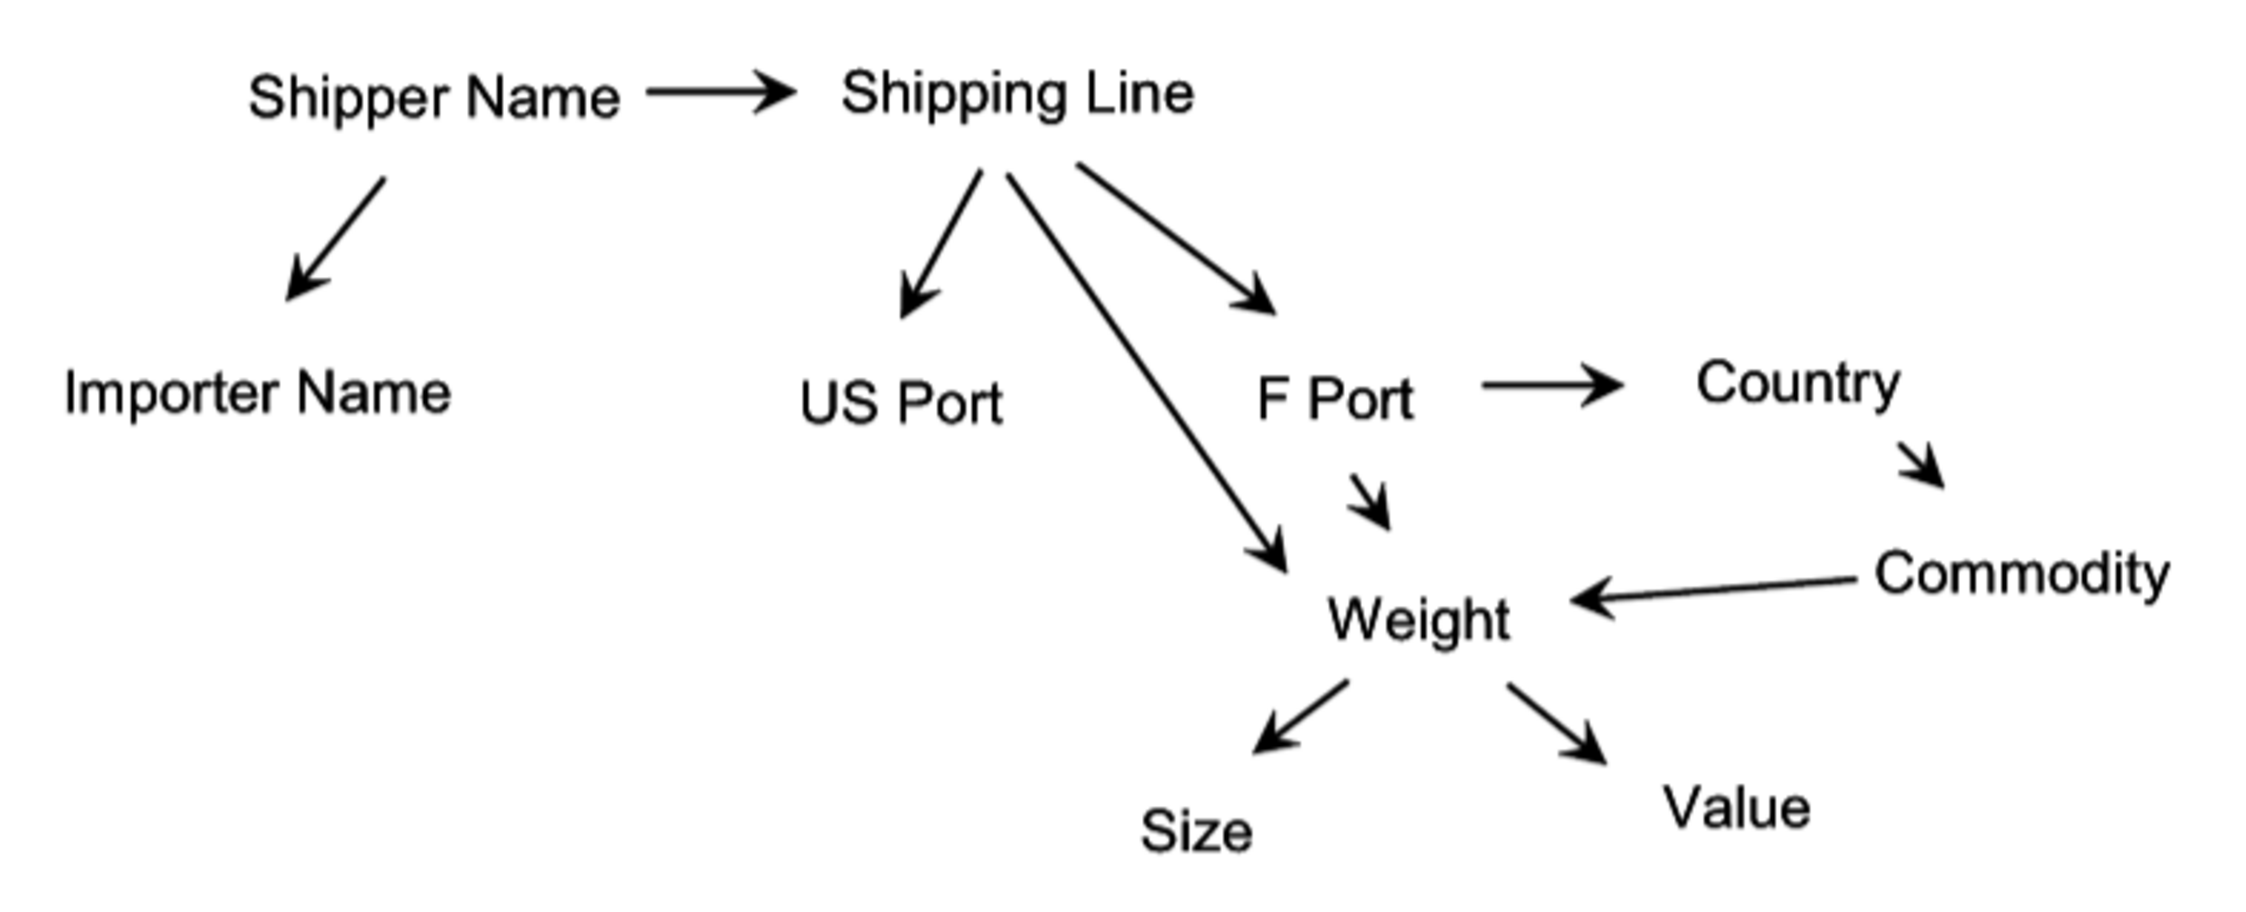

In [2]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

CI (Shipper Name, Value | F Port)? <b> Dependent </b>

CI (Shipper Name, Value | Shipping Line)? <b> Independent </b>

CI (Foreign Port, Commodity | Country)? <b> Independent </b>

CI (Foreign Port, Commodity | County, Weight)? <b> Dependent </b>

2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

Shipping Line: CSCO (80%), ASCO (20%)

Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

Foreign Port | Shipping Line = ASCO: Vancouver (100%)

US Port | Shipping Line = ASCO: Seattle (100%)

US Port | Shipping Line = CSCO: Seattle (20%), Los Angeles (80%)

Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (30%), Medium (20%), Heavy (50%)

Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (60%), Heavy (30%)

Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (15%), Medium (15%), Heavy (70%)

Which of the following packages is most anomalous?

a) A heavy package shipped from Vancouver to Seattle by ASCO

b) A heavy package shipped from Vancouver to Seattle by CSCO

c) A heavy package shipped from Yokohama to Los Angeles by CSCO

To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

(Your answers here, including all calculations) <br>
<b>a)</b> P(ASCO) * P(Vancouver | ASCO) * P(Seattle | ASCO) * P(Heavy | ASCO) = 0.2 * 1 * 1 * 0.7 = 14% <br>
<b>b)</b> P(CSCO) * P(Vancouver | CSCO) * P(Seattle | CSCO) * P(Heavy | CSCO) = 0.8 * 0.6 * 0.2 * 0.5 = 4.8% <br>
<b>c)</b> P(CSCO) * P(Yokohama | CSCO) * P(Los Angeles | CSCO) * P(Heavy | CSCO) = 0.8 * 0.4 * 0.8 * 0.5 = 12.8%

### Q2. Bayesian Network Learning (35 points)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [3]:
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

A  B  C  D  E  F
0  1  0  0  0  1  1
1  0  0  0  1  0  1
2  1  1  0  1  1  1
3  1  0  0  1  1  1
4  2  0  1  0  1  1

a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points)

b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)

c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)   

In [4]:
# your answers here
# a)
hc = HillClimbSearch(train)
best_model = hc.estimate(scoring_method=BicScore(train))
print(best_model.edges())

  0%|          | 4/1000000 [00:00<9:22:30, 29.63it/s] 

[('B', 'A'), ('D', 'A'), ('E', 'A')]


In [5]:
# b)
best_model = BayesianModel(best_model.edges()) # convert DAG to BayesianModel
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in best_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
for thenode in best_model.nodes():
    print(best_model.local_independencies(thenode))

CPD of B:
+------+--------+
| B(0) | 0.5015 |
+------+--------+
| B(1) | 0.4985 |
+------+--------+
CPD of A:
+------+----------------------+-----+----------------------+
| B    | B(0)                 | ... | B(1)                 |
+------+----------------------+-----+----------------------+
| D    | D(0)                 | ... | D(1)                 |
+------+----------------------+-----+----------------------+
| E    | E(0)                 | ... | E(1)                 |
+------+----------------------+-----+----------------------+
| A(0) | 0.4965893587994543   | ... | 0.001349527665317139 |
+------+----------------------+-----+----------------------+
| A(1) | 0.5006821282401092   | ... | 0.5033738191632928   |
+------+----------------------+-----+----------------------+
| A(2) | 0.001364256480218281 | ... | 0.4939271255060729   |
+------+----------------------+-----+----------------------+
| A(3) | 0.001364256480218281 | ... | 0.001349527665317139 |
+------+----------------------+-----

C:\Users\Jeff\anaconda3\envs\ds\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


In [6]:
# c)
test_x = test.loc[:,["B","D","E"]] # Get B, D, E
# predicted_test = temp_predict(best_model, test_x)
predicted_test = best_model.predict(test_x)
print("Out of sample:", (test.loc[:,'A'].reset_index(drop=True) == predicted_test['A']).mean())

100%|██████████| 8/8 [00:00<00:00, 1599.89it/s]


Out of sample: 0.5645


C:\Users\Jeff\anaconda3\envs\ds\lib\site-packages\pgmpy\models\BayesianNetwork.py:744: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)  

d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [7]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head()

crime_type Category   day_Sun   day_Mon  \
0                          ARSON: BY FIRE      P1P  0.138810  0.135977   
1     ASSAULT: AGG PO HANDS NO/MIN INJURY       P2  0.151852  0.118519   
2            ASSAULT: AGGRAVATED: HANDGUN      P1V  0.149912  0.139405   
3  ASSAULT: AGGRAVATED: OTHER DANG WEAPON      P1V  0.125000  0.139000   
4      ASSAULT: AGGRAVATED: OTHER FIREARM      P1V  0.156863  0.107843   

    day_Tue   day_Wed   day_Thu   day_Fri   day_Sat    hour_0  ...  \
0  0.155807  0.121813  0.130312  0.147309  0.169972  0.073654  ...   
1  0.162963  0.122222  0.129630  0.129630  0.185185  0.055556  ...   
2  0.141506  0.131349  0.136953  0.133100  0.167776  0.040630  ...   
3  0.148000  0.153000  0.133000  0.142000  0.160000  0.034000  ...   
4  0.166667  0.117647  0.147059  0.117647  0.186275  0.009804  ...   

   community_area_68  community_area_69  community_area_70  community_area_71  \
0           0.019830           0.016997           0.019830           0.022663   
1           0.037037           0.048148           0.018519           0.025926   
2           0.035377           0.031524           0.013310           0.042732   
3           0.028000           0.030000           0.014000           0.037000   
4           0.029412           0.019608           0.009804           0.019608   

   community_area_72  community_area_73  community_area_74  community_area_75  \
0           0.005666           0.000000           0.002833           0.005666   
1           0.003704           0.003704           0.003704           0.011111   
2           0.002102           0.017863           0.000000           0.012259   
3           0.003000           0.010000           0.002000           0.002000   
4           0.000000           0.000000           0.000000           0.009804   

   community_area_76  community_area_77  
0           0.000000           0.002833  
1           0.011111           0.007407  
2           0.002102           0.003152  
3           0.003000           0.006000  
4           0.000000           0.000000  

[5 rows x 110 columns]

In [8]:
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

Community Area Number COMMUNITY AREA NAME   centroid_x   centroid_y  \
0                      1         Rogers Park  1164399.219  1947666.815   
1                      2          West Ridge  1158307.200  1943243.722   
2                      3              Uptown  1168228.082  1930980.022   
3                      4      Lincoln Square  1159618.804  1933105.743   
4                      5        North Center  1161104.228  1924056.010   

   PERCENT OF HOUSING CROWDED  PERCENT HOUSEHOLDS BELOW POVERTY  \
0                         7.7                              23.6   
1                         7.8                              17.2   
2                         3.8                              24.0   
3                         3.4                              10.9   
4                         0.3                               7.5   

   PERCENT AGED 16+ UNEMPLOYED  PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  \
0                          8.7                                          18.2   
1                          8.8                                          20.8   
2                          8.9                                          11.8   
3                          8.2                                          13.4   
4                          5.2                                           4.5   

   PERCENT AGED UNDER 18 OR OVER 64  PER CAPITA INCOME   \
0                              27.5               23939   
1                              38.5               23040   
2                              22.2               35787   
3                              25.5               37524   
4                              26.2               57123   

   PERCENT OF HOUSING UNITS VACANT  NUM_CRIMES_2016  
0                        11.870556             3420  
1                         9.870385             3068  
2                         8.672137             3330  
3                         8.600422             1859  
4                        10.100636             1280

In [9]:
# Setup
from sklearn.cluster import KMeans

# Create Dataframe with 24 hours
hours = ['hour_' + str(i) for i in range(0,24)]
dfHour = data3[hours]

# K Means = 3 clusters
km = KMeans(n_clusters = 3, random_state=9)
km_model = km.fit(dfHour)

# Add Kmean to DF
dfHour['KM'] = km_model.labels_
dfHour

C:\Users\Jeff\AppData\Local\Temp\ipykernel_79644\2681182956.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfHour['KM'] = km_model.labels_


hour_0    hour_1    hour_2    hour_3    hour_4    hour_5    hour_6  \
0    0.073654  0.079320  0.076487  0.087819  0.082153  0.073654  0.039660   
1    0.055556  0.070370  0.033333  0.014815  0.025926  0.003704  0.007407   
2    0.040630  0.039580  0.033275  0.036778  0.018564  0.014011  0.012609   
3    0.034000  0.026000  0.018000  0.009000  0.010000  0.015000  0.020000   
4    0.009804  0.009804  0.029412  0.009804  0.009804  0.019608  0.039216   
..        ...       ...       ...       ...       ...       ...       ...   
114  0.008185  0.008526  0.005343  0.005570  0.004774  0.003979  0.007844   
115  0.054622  0.042017  0.042017  0.037815  0.033613  0.012605  0.004202   
116  0.050834  0.030500  0.017080  0.017893  0.006913  0.008133  0.006100   
117  0.073801  0.029520  0.022140  0.040590  0.036900  0.011070  0.018450   
118  0.020408  0.054422  0.020408  0.020408  0.006803  0.000000  0.000000   

       hour_7    hour_8    hour_9  ...   hour_15   hour_16   hour_17  \
0    0.033994  0.014164  0.016997  ...  0.019830  0.025496  0.022663   
1    0.014815  0.018519  0.029630  ...  0.077778  0.048148  0.059259   
2    0.021366  0.025569  0.034676  ...  0.052189  0.059895  0.056392   
3    0.017000  0.033000  0.036000  ...  0.058000  0.073000  0.078000   
4    0.019608  0.000000  0.029412  ...  0.009804  0.107843  0.117647   
..        ...       ...       ...  ...       ...       ...       ...   
114  0.013868  0.018074  0.025804  ...  0.102535  0.100602  0.095487   
115  0.008403  0.008403  0.025210  ...  0.079832  0.050420  0.067227   
116  0.007727  0.015047  0.015860  ...  0.052460  0.042294  0.036194   
117  0.007380  0.029520  0.025830  ...  0.040590  0.051661  0.051661   
118  0.013605  0.047619  0.054422  ...  0.040816  0.047619  0.013605   

      hour_18   hour_19   hour_20   hour_21   hour_22   hour_23  KM  
0    0.022663  0.053824  0.033994  0.033994  0.042493  0.062323   1  
1    0.044444  0.044444  0.077778  0.044444  0.074074  0.044444   1  
2    0.062347  0.051839  0.053240  0.066550  0.055692  0.056042   1  
3    0.068000  0.066000  0.059000  0.038000  0.051000  0.041000   1  
4    0.058824  0.068627  0.078431  0.068627  0.049020  0.088235   1  
..        ...       ...       ...       ...       ...       ...  ..  
114  0.080823  0.066614  0.043424  0.024781  0.016256  0.010231   2  
115  0.042017  0.063025  0.063025  0.046218  0.075630  0.046218   1  
116  0.057747  0.086214  0.078894  0.085401  0.090281  0.075641   1  
117  0.055351  0.073801  0.044280  0.033210  0.084871  0.044280   1  
118  0.054422  0.088435  0.013605  0.061224  0.061224  0.047619   0  

[119 rows x 25 columns]

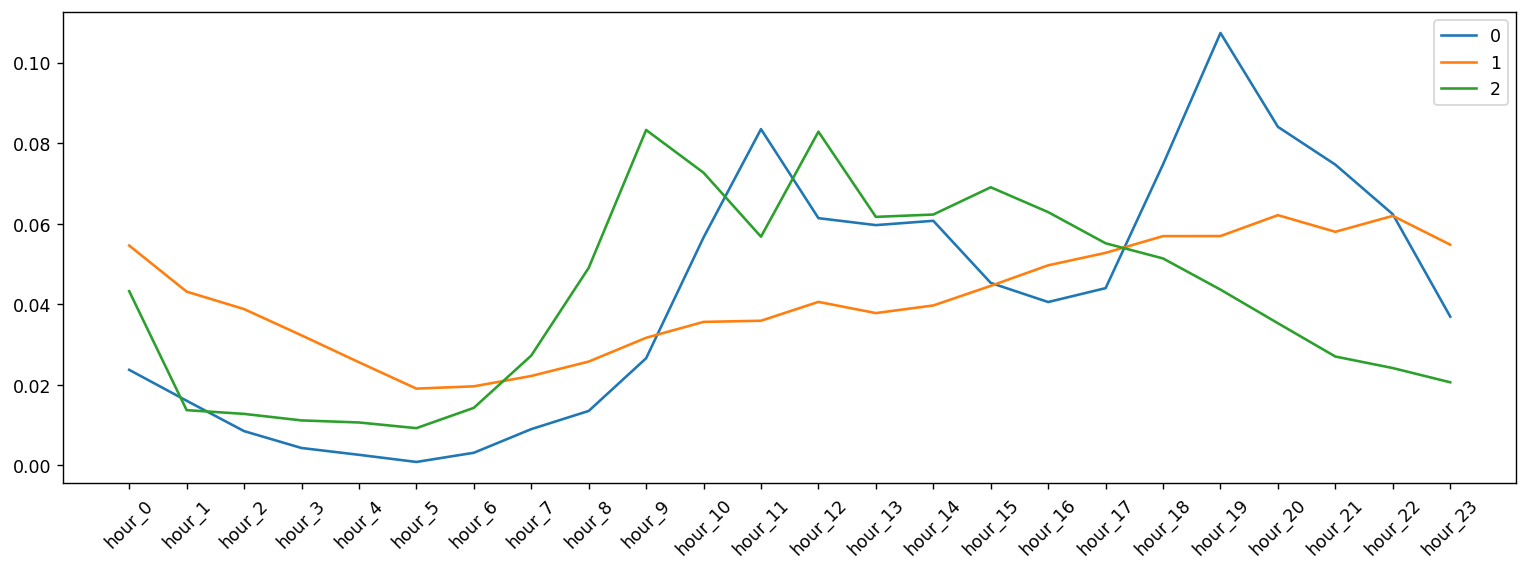

In [10]:
# a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster. (5 pts)
import matplotlib.pyplot as plt

dfHour_mean = dfHour.groupby(['KM']).agg('mean')

ax = plt.figure(figsize=(15,5), dpi=125)
plt.plot(dfHour_mean.T)
plt.legend(dfHour_mean.T)
plt.xticks(rotation=45)
plt.show()

b) Describe the three different hour-of-day trends represented by these three clusters (5 pts). <br>
<b> 
Cluster 0, has a tend of decreasing crime rate from hour 19 to hour 5. It then began to rise until hour 17 when there is a large spike in crime rate.
<br><br>
Cluster 1, has a smoother trend throughout 24 hours. We can see a "pattern" where the crime rate increased during the day and decreased during the night.
<br><br>
Cluster 2, has a similar trend to cluster 0, but it does not have the "sharp" rise at hour 17. It also started to decrease earlier than the other two clusters.
</b>

In [11]:
# c) Do you notice any consistent trends about which crime types are assigned to which cluster? Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)
import re
# list(data3.columns) # Find out what columns there are!

# K Means cluster for the whole data
data3['KM'] = km_model.labels_
dfC = data3.copy()
dfC['crime_type'] = [re.sub(r':(.*)', '', str(x)) for x in dfC['crime_type']]
dfC.groupby(['KM', 'crime_type'])['crime_type'].count()


KM  crime_type                      
0   DECEPTIVE PRACTICE                   1
    GAMBLING                             1
    INTERFERENCE WITH PUBLIC OFFICER     1
    NARCOTICS                           12
    OTHER OFFENSE                        5
    PUBLIC PEACE VIOLATION               1
    WEAPONS VIOLATION                    1
1   ARSON                                1
    ASSAULT                              5
    BATTERY                             11
    BURGLARY                             2
    CRIM SEXUAL ASSAULT                  2
    CRIMINAL DAMAGE                      5
    CRIMINAL TRESPASS                    3
    DECEPTIVE PRACTICE                   2
    HOMICIDE                             1
    INTERFERENCE WITH PUBLIC OFFICER     1
    LIQUOR LAW VIOLATION                 1
    MOTOR VEHICLE THEFT                  3
    NARCOTICS                            2
    OFFENSE INVOLVING CHILDREN           1
    OTHER OFFENSE                        5
    PROSTITUTION 

<b>From the list above, we can see that in...<br> 
    Cluster 0 is dominated by the <em> NARCOTICS </em> <br>
    Cluster 1 is dominated by <em> BATTERY </em> with <em> ROBBERY </em> coming in secound. <br>
    Cluster 2 is dominated by <em> DECEPTIVE PRACTICE </em> with <em> OTHER OFFENSE </em> coming second.

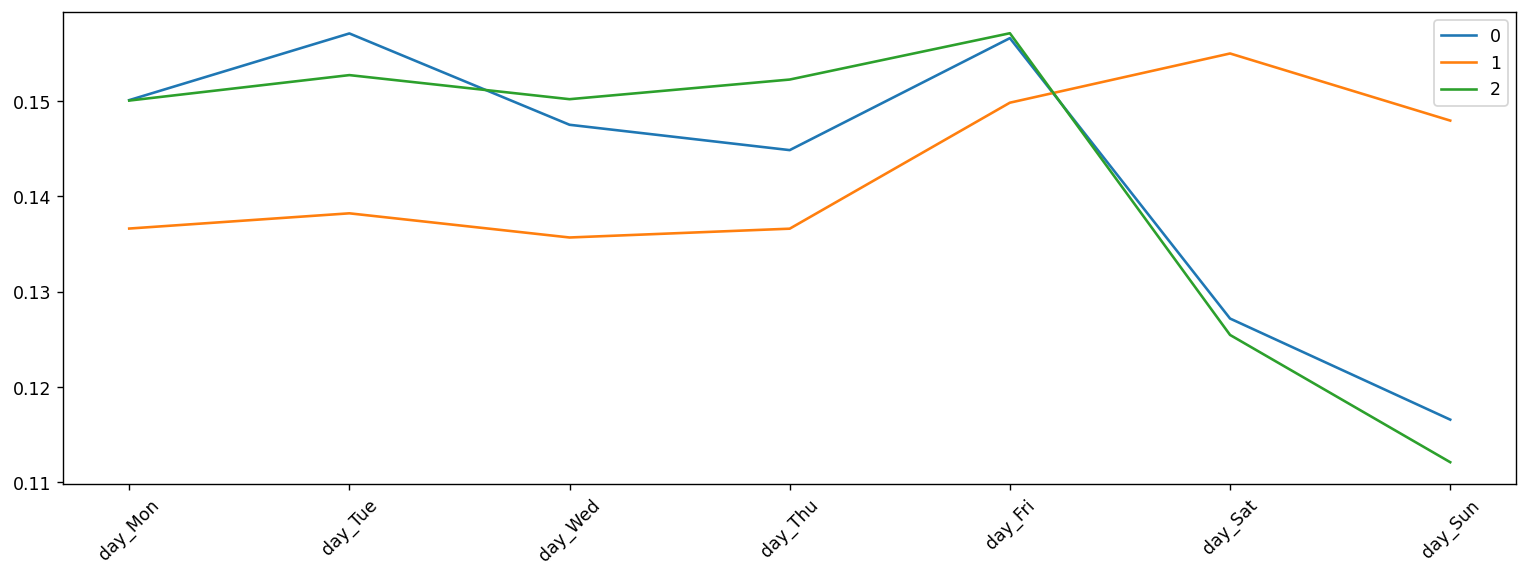

In [12]:
# d) Do the three clusters have different day-of-week trends? Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences. (5 pts)
# [re.match(r'\b(day_.*)', str(x)) for x in data3.columns]
DOW = ['day_Mon', 'day_Tue', 'day_Wed', 'day_Thu', 'day_Fri', 'day_Sat', 'day_Sun', 'KM']
dfD = data3[DOW]
dfD_cluster = dfD.groupby(['KM']).agg('mean')

ax = plt.figure(figsize=(15,5), dpi=125)
plt.plot(dfD_cluster.T)
plt.legend(dfD_cluster.T)
plt.xticks(rotation=45)
plt.show()

<b>From the line graph we can see that Cluster 0 and 2 has very similar trend - high during the weekdays and lower during the weekends. <br>
As for Cluster 1, we see that the weekdays crime rate is lower than the weekends. 

In [13]:
# e) Do the three clusters affect different types of communities/neighborhoods?
com = ['community_area_' + str(i) for i in range(1, 78)]
dfE = data3[com]
dfE['KM'] = data3['KM']
dfE_cluster = dfE.groupby(['KM']).agg('mean')
# Find highest crime by community (Top 5)
print(dfE_cluster.loc[0].nlargest(5))
print(dfE_cluster.loc[1].nlargest(5))
print(dfE_cluster.loc[2].nlargest(5))

community_area_25    0.159341
community_area_26    0.072619
community_area_29    0.069133
community_area_23    0.064709
community_area_27    0.049285
Name: 0, dtype: float64
community_area_25    0.073088
community_area_29    0.038589
community_area_43    0.032128
community_area_23    0.031061
community_area_67    0.029792
Name: 1, dtype: float64
community_area_8     0.053181
community_area_32    0.052905
community_area_25    0.048313
community_area_28    0.038063
community_area_6     0.025938
Name: 2, dtype: float64


C:\Users\Jeff\AppData\Local\Temp\ipykernel_79644\47818598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfE['KM'] = data3['KM']


In [14]:
km0_com = [25, 26, 29, 23, 27]
km1_com = [25, 29, 43, 23, 67]
km2_com = [8, 32, 25, 28, 6]

display(data4.loc[data4['Community Area Number'].isin(km0_com)])
display(data4.loc[data4['Community Area Number'].isin(km1_com)])
display(data4.loc[data4['Community Area Number'].isin(km2_com)])

Community Area Number COMMUNITY AREA NAME   centroid_x   centroid_y  \
22                     23       Humboldt park  1151216.159  1906926.141   
24                     25              Austin  1140839.462  1903174.321   
25                     26  West Garfield Park  1148754.852  1898785.758   
26                     27  East Garfield Park  1155086.641  1898653.301   
28                     29      North Lawndale  1152306.328  1892568.863   

    PERCENT OF HOUSING CROWDED  PERCENT HOUSEHOLDS BELOW POVERTY  \
22                        14.8                              33.9   
24                         6.3                              28.6   
25                         9.4                              41.7   
26                         8.2                              42.4   
28                         7.4                              43.1   

    PERCENT AGED 16+ UNEMPLOYED  PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  \
22                         17.3                                          35.4   
24                         22.6                                          24.4   
25                         25.8                                          24.5   
26                         19.6                                          21.3   
28                         21.2                                          27.6   

    PERCENT AGED UNDER 18 OR OVER 64  PER CAPITA INCOME   \
22                              38.0               13781   
24                              37.9               15957   
25                              43.6               10934   
26                              43.2               12961   
28                              42.7               12034   

    PERCENT OF HOUSING UNITS VACANT  NUM_CRIMES_2016  
22                        15.839488             7522  
24                        14.188517            15719  
25                        27.504936             5340  
26                        19.899589             4727  
28                        21.888178             8073

Community Area Number COMMUNITY AREA NAME   centroid_x   centroid_y  \
22                     23       Humboldt park  1151216.159  1906926.141   
24                     25              Austin  1140839.462  1903174.321   
28                     29      North Lawndale  1152306.328  1892568.863   
42                     43         South Shore  1191640.433  1856742.384   
66                     67      West Englewood  1166461.104  1861781.980   

    PERCENT OF HOUSING CROWDED  PERCENT HOUSEHOLDS BELOW POVERTY  \
22                        14.8                              33.9   
24                         6.3                              28.6   
28                         7.4                              43.1   
42                         2.8                              31.1   
66                         4.8                              34.4   

    PERCENT AGED 16+ UNEMPLOYED  PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  \
22                         17.3                                          35.4   
24                         22.6                                          24.4   
28                         21.2                                          27.6   
42                         20.0                                          14.0   
66                         35.9                                          26.3   

    PERCENT AGED UNDER 18 OR OVER 64  PER CAPITA INCOME   \
22                              38.0               13781   
24                              37.9               15957   
28                              42.7               12034   
42                              35.7               19398   
66                              40.7               11317   

    PERCENT OF HOUSING UNITS VACANT  NUM_CRIMES_2016  
22                        15.839488             7522  
24                        14.188517            15719  
28                        21.888178             8073  
42                        18.541882             7673  
66                        22.388616             6442

Community Area Number COMMUNITY AREA NAME   centroid_x   centroid_y  \
5                       6           Lake View  1169108.569  1922712.107   
7                       8     Near North Side  1175512.220  1906089.147   
24                     25              Austin  1140839.462  1903174.321   
27                     28      Near West Side  1167030.371  1898359.955   
31                     32                Loop  1176373.765  1899831.267   

    PERCENT OF HOUSING CROWDED  PERCENT HOUSEHOLDS BELOW POVERTY  \
5                          1.1                              11.4   
7                          1.9                              12.9   
24                         6.3                              28.6   
27                         3.8                              20.6   
31                         1.5                              14.7   

    PERCENT AGED 16+ UNEMPLOYED  PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  \
5                           4.7                                           2.6   
7                           7.0                                           2.5   
24                         22.6                                          24.4   
27                         10.7                                           9.6   
31                          5.7                                           3.1   

    PERCENT AGED UNDER 18 OR OVER 64  PER CAPITA INCOME   \
5                               17.0               60058   
7                               22.6               88669   
24                              37.9               15957   
27                              22.2               44689   
31                              13.5               65526   

    PERCENT OF HOUSING UNITS VACANT  NUM_CRIMES_2016  
5                          8.573972             5671  
7                         17.077160             9847  
24                        14.188517            15719  
27                        11.790159             8891  
31                        24.629080             8471

<b>From the comparison above, we can see that cluster 0 and 1 communities are similar - they even share similar communities. According to the chart, we can see that in cluster 0 and 1, communities are earning less than 20,000, has a large number of people under 18 and over 65 with high percentage of household being below poverty, and around 25% are without high school diploma. <br>
In cluster 2, we see the communities income averaging around 54,979.8 with a low unemployment rate. <br>
Similarity between cluster 2 and the others clusters is the percent of housing units vacant.

In [15]:
# f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)
dfF = data3.groupby(['KM', 'Category'])['Category'].count().to_frame()
dfF

Category
KM Category          
0  P2              22
1  P1P              9
   P1V             24
   P2              31
2  P1P              6
   P2              27

<b>According to the chart above, Cluster 0 only has P2 which is the "less serious" crimes. <br>
Cluster 1 has 9 in P1P (Property Crime (serious)), 24 in P1V (Violent Crime (serious)), and 31 in P2. <br> Cluster 2 has 6 in P1P and 27 in P2.

In [16]:
from sklearn.metrics import silhouette_score
dfG = data3.loc[:, "day_Sun":"day_Sat"]

In [17]:
# gi)  k-means
cluster = {}
for i in range(2,11):
    km = KMeans(random_state=9, n_clusters=i)
    res = km.fit_predict(dfG)
    score = silhouette_score(dfG, res)
    print ("For n_clusters = {},".format(i) + " silhouette score is: {})".format(score))
    cluster[i] = score
    
max_cluster = max(cluster, key=cluster.get)

For n_clusters = 2, silhouette score is: 0.23496703980224018)
For n_clusters = 3, silhouette score is: 0.22562505812553876)
For n_clusters = 4, silhouette score is: 0.22942282228420055)
For n_clusters = 5, silhouette score is: 0.2398335428706661)
For n_clusters = 6, silhouette score is: 0.24507597372919188)
For n_clusters = 7, silhouette score is: 0.13874424960829884)
For n_clusters = 8, silhouette score is: 0.13114273990693637)
For n_clusters = 9, silhouette score is: 0.1529175173719486)
For n_clusters = 10, silhouette score is: 0.15804299868947805)


In [18]:
km = KMeans(n_clusters=max_cluster, random_state=9)
model = km.fit(dfG)
dfG_km = dfG.copy()
dfG_km['KM'] = model.labels_
print('Using Cluster:' + str(max_cluster))
print(dfG_km['KM'].value_counts())

Using Cluster:6
1    65
0    31
2    12
5     7
3     2
4     2
Name: KM, dtype: int64


In [19]:
# gii) Gaussian mixture models
from sklearn.mixture import GaussianMixture
cluster = {}
for i in range(2,11):
    gm = GaussianMixture(random_state=9, n_components=i)
    res = gm.fit_predict(dfG)
    score = silhouette_score(dfG, res)
    print ("For n_clusters = {},".format(i) + " silhouette score is: {})".format(score))
    cluster[i] = score
    
max_cluster = max(cluster, key=cluster.get)

For n_clusters = 2, silhouette score is: 0.5738016662618166)
For n_clusters = 3, silhouette score is: 0.3502061648663461)
For n_clusters = 4, silhouette score is: 0.3262898263360249)
For n_clusters = 5, silhouette score is: 0.20790661559528412)
For n_clusters = 6, silhouette score is: 0.16269470973666011)
For n_clusters = 7, silhouette score is: 0.16650584665306856)
For n_clusters = 8, silhouette score is: 0.1004441964492813)
For n_clusters = 9, silhouette score is: 0.09652872671152998)
For n_clusters = 10, silhouette score is: 0.0984543660223311)


In [20]:
gm = GaussianMixture(n_components=max_cluster, random_state=9)
model = gm.fit_predict(dfG)
dfG_gm = dfG.copy()
dfG_gm['GM'] = model
print('Using Cluster:' + str(max_cluster))
print(dfG_gm['GM'].value_counts())

Using Cluster:2
1    116
0      3
Name: GM, dtype: int64


In [21]:
# giii) Bottom-up hierarchical clustering with "single link" distance metric 
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
from scipy.cluster.hierarchy import fcluster

Z_single = linkage(dfG, 'single')
cluster = {}
for i in range(2,11):
    zs = fcluster(Z_single, i, criterion='maxclust')
    score = silhouette_score(dfG, zs)
    print ("For n_clusters = {},".format(i) + " silhouette score is: {})".format(score))
    cluster[i] = score
    
max_cluster = max(cluster, key=cluster.get)

For n_clusters = 2, silhouette score is: 0.6377648080667613)
For n_clusters = 3, silhouette score is: 0.5568477382969328)
For n_clusters = 4, silhouette score is: 0.40557775075981545)
For n_clusters = 5, silhouette score is: 0.3877038188748669)
For n_clusters = 6, silhouette score is: 0.39007619510221897)
For n_clusters = 7, silhouette score is: 0.34621844820394365)
For n_clusters = 8, silhouette score is: 0.328998157643559)
For n_clusters = 9, silhouette score is: 0.3254219274892415)
For n_clusters = 10, silhouette score is: 0.31321510390503554)


In [22]:
zs = fcluster(Z_single, max_cluster, criterion='maxclust') 
dfG_zs = dfG.copy()
dfG_zs['ZS'] = zs
print('Using Cluster:' + str(max_cluster))
print (dfG_zs['ZS'].value_counts())

Using Cluster:2
1    118
2      1
Name: ZS, dtype: int64


In [23]:
# giv) Bottom-up hierarchical clustering with "complete link" distance metric
Z_complete = linkage(dfG, 'complete')
cluster = {}
for i in range(2,11):
    zc = fcluster(Z_complete, i, criterion='maxclust')
    score = silhouette_score(dfG, zc)
    print ("For n_clusters = {},".format(i) + " silhouette score is: {})".format(score))
    cluster[i] = score
    
max_cluster = max(cluster, key=cluster.get)

For n_clusters = 2, silhouette score is: 0.6100646113547024)
For n_clusters = 3, silhouette score is: 0.172687181465661)
For n_clusters = 4, silhouette score is: 0.192151693747686)
For n_clusters = 5, silhouette score is: 0.15025207822499756)
For n_clusters = 6, silhouette score is: 0.15229681572228068)
For n_clusters = 7, silhouette score is: 0.1492626761610943)
For n_clusters = 8, silhouette score is: 0.10130440123428011)
For n_clusters = 9, silhouette score is: 0.10066503899164744)
For n_clusters = 10, silhouette score is: 0.11061132431547048)


In [24]:
zc = fcluster(Z_complete, max_cluster, criterion='maxclust') 
dfG_zc = dfG.copy()
dfG_zc['ZC'] = zc
print('Using Cluster:' + str(max_cluster))
print (dfG_zc['ZC'].value_counts())

Using Cluster:2
2    117
1      2
Name: ZC, dtype: int64


<b> Other than the KMean, every method used performs well with a "cluster" of two with minor differences among them. Kmean seems to perform best with 6 clusters instead of 2 like the others. Notable similarities are that all of them tends to have a bias towards a cluster - kmeans to be more spread out but this could due to the larger number of clusters.